# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
from stargazer.stargazer import Stargazer


# Import and Clean Data

In [2]:
# import the excel data from the data subfolder that starts 
ca_21 = pd.read_excel('data/21in05ca.xlsx', header=3)[3:5]
fl_21 = pd.read_excel('data/21in10fl.xlsx', header=3)[3:5]
hi_21 = pd.read_excel('data/21in12hi.xlsx', header=3)[3:5]
mn_21 = pd.read_excel('data/21in24mn.xlsx', header=3)[3:5]
nv_21 = pd.read_excel('data/21in29nv.xlsx', header=3)[3:5]
nj_21 = pd.read_excel('data/21in31nj.xlsx', header=3)[3:5]
or_21 = pd.read_excel('data/21in38or.xlsx', header=3)[3:5]
tn_21 = pd.read_excel('data/21in43tn.xlsx', header=3)[3:5]
tx_21 = pd.read_excel('data/21in44tx.xlsx', header=3)[3:5]
wa_21 = pd.read_excel('data/21in48wa.xlsx', header=3)[3:5]

ca_16 = pd.read_excel('data/16in05ca.xls', header=3)[3:5]
fl_16 = pd.read_excel('data/16in10fl.xls', header=3)[3:5]
hi_16 = pd.read_excel('data/16in12hi.xls', header=3)[3:5]
mn_16 = pd.read_excel('data/16in24mn.xls', header=3)[3:5]
nv_16 = pd.read_excel('data/16in29nv.xls', header=3)[3:5]
nj_16 = pd.read_excel('data/16in31nj.xls', header=3)[3:5]
or_16 = pd.read_excel('data/16in38or.xls', header=3)[3:5]
tn_16 = pd.read_excel('data/16in43tn.xls', header=3)[3:5]
tx_16 = pd.read_excel('data/16in44tx.xls', header=3)[3:5]
wa_16 = pd.read_excel('data/16in48wa.xls', header=3)[3:5]

# create df with 2021 tax rates
tax_rates = pd.DataFrame({'State': ['California', 'Florida', 'Hawaii', 'Minnesota', 'Nevada', 'New Jersey', 'Oregon', 'Tennessee', 'Texas', 'Washington'],
                          'Tax Rate 2021': [0.133, 0, 0.11, 0.0985, 0, 0.1075, 0.099, 0, 0, 0],
                          'Tax Rate 2016': [0.133, 0, 0.0825, 0.0985, 0, 0.0897, 0.099, 0, 0.06, 0]})
tax_rates['Net of Tax 2021'] = 1 - tax_rates['Tax Rate 2021']

In [3]:
# clean the dataframes
list_df16 = [ca_16, fl_16, hi_16, mn_16, nv_16, nj_16, or_16, tn_16, tx_16, wa_16]
list_df21 = [ca_21, fl_21, hi_21, mn_21, nv_21, nj_21, or_21, tn_21, tx_21, wa_21]
group_t = ['California', 'Hawaii', 'Minnesota', 'New Jersey', 'Oregon']

list_of_lists = [list_df16, list_df21]

for i, list_df in enumerate(list_of_lists):
    for df in list_df:
        # sum the returns in the columns
        df['State'] = df.iloc[0,0]
        df['State'] = df['State'].str.title()
        df.drop(index=3, inplace=True)
        
        # add year column
        if i == 0:
            df['Year'] = 2016
        else:
            df['Year'] = 2021
        
        df['Total Returns'] = df.iloc[:,2:12].sum(axis=1)
        if (df.iloc[:,1] != df['Total Returns']).all() != 0:
            print(f"error in {df['State'].item()}, year {df['Year'].item()}, discrepancy of {(df.iloc[:,1] - df['Total Returns']).item():.0f} using the calculated total")
        df.drop(columns=df.columns[1:11], inplace=True)
        df.rename(columns={'$1,000,000\nor\nmore': 'High Income Returns', 'Unnamed: 0': 'Series Name'}, inplace=True)
        df['High Income Share'] = df['High Income Returns'] / df['Total Returns']
        df['High Income Share (%)'] = df['High Income Share']*100
        if df['State'].item() in group_t:
            df['Treatment'] = True
        else:
            df['Treatment'] = False


error in Florida, year 2016, discrepancy of -10 using the calculated total
error in Hawaii, year 2016, discrepancy of -10 using the calculated total
error in Nevada, year 2016, discrepancy of 10 using the calculated total
error in Oregon, year 2016, discrepancy of -10 using the calculated total
error in Tennessee, year 2016, discrepancy of -10 using the calculated total
error in Texas, year 2016, discrepancy of -10 using the calculated total
error in Washington, year 2016, discrepancy of -10 using the calculated total
error in California, year 2021, discrepancy of -10 using the calculated total
error in Hawaii, year 2021, discrepancy of -10 using the calculated total
error in Minnesota, year 2021, discrepancy of 10 using the calculated total
error in Oregon, year 2021, discrepancy of -10 using the calculated total
error in Tennessee, year 2021, discrepancy of -10 using the calculated total


In [4]:
# concatenate the dataframes
df21 = pd.concat(list_df21)
df16 = pd.concat(list_df16)

# 2.b 

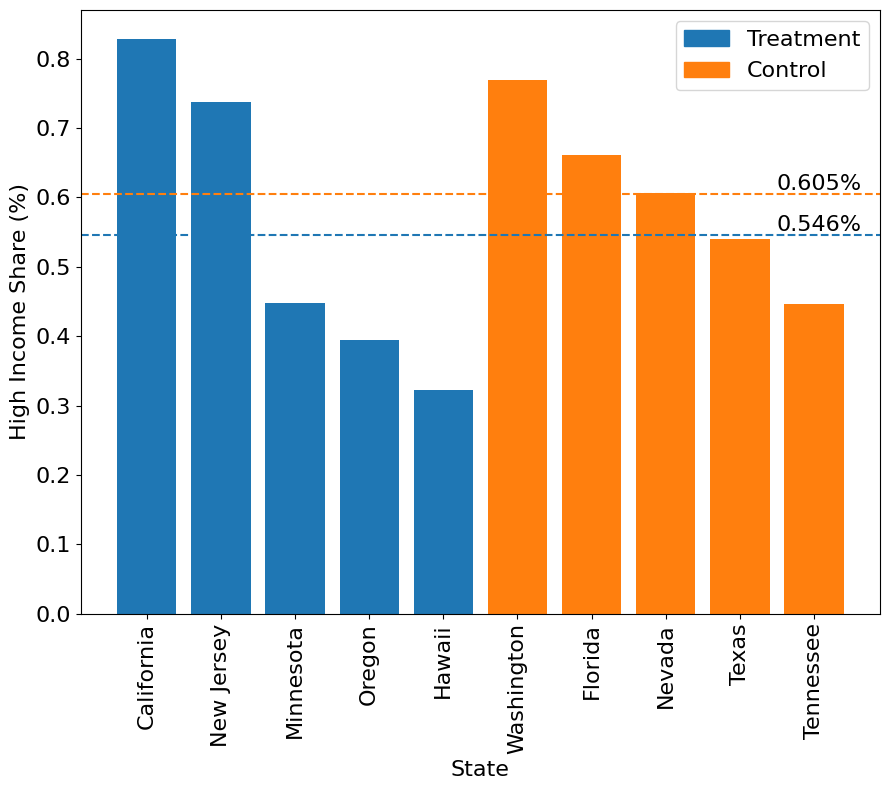

In [5]:
# prepare the data for plotting
df21.sort_values(['Treatment','High Income Share'], ascending=[False,False], inplace=True)
colors = df21['Treatment'].map({True: 'tab:blue', False: 'tab:orange'})
group_t_avg = df21[df21['Treatment']]['High Income Share (%)'].mean()
group_c_avg = df21[~df21['Treatment']]['High Income Share (%)'].mean()

# plot the data
plt.figure(figsize=(9,8))
plt.bar(df21['State'], df21['High Income Share (%)'], color=colors)
plt.axhline(y=group_t_avg, color='tab:blue', linestyle='--')
plt.axhline(y=group_c_avg, color='tab:orange', linestyle='--')

# add the average as text to the plot
plt.text(8.5, group_t_avg, f'{group_t_avg:.3f}%', verticalalignment='bottom', fontsize=16)
plt.text(8.5, group_c_avg, f'{group_c_avg:.3f}%', verticalalignment='bottom', fontsize=16)

plt.ylabel('High Income Share (%)', fontsize=16)
plt.xlabel('State', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation=90)
group_t_patch = mpatches.Patch(color='tab:blue', label='Treatment')
group_c_patch = mpatches.Patch(color='tab:orange', label='Control')
plt.legend(handles=[group_t_patch, group_c_patch], fontsize=16)
plt.tight_layout()
plt.savefig('high_income_share_by_state.png')
plt.show()

# 2.d

In [165]:
# create one dataframe with all the data
df = pd.concat([df16, df21], axis=0)
df = pd.merge(df, tax_rates, on='State')

# add post and interaction variable
df['2021'] = df['Year'].map({2016: 0, 2021: 1})
df['Treatmentx2021'] = df['2021'] * df['Treatment']

df['High Income Share'] = df['High Income Share'].astype(float)
df['High Income Share (%)'] = df['High Income Share (%)'].astype(float)
df['Treatment'] = df['Treatment'].astype(int)

df['log_net_of_tax'] = np.log(df['Net of Tax 2021'])
df['log_HIR'] = np.log(df['High Income Returns'])


In [166]:
Y = df['log_HIR']
X1 = df[['Treatment', '2021', 'Treatmentx2021']]
X1 = sm.add_constant(X1)
model1 = sm.OLS(Y, X1).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                log_HIR   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.8508
Date:                Sun, 21 Apr 2024   Prob (F-statistic):              0.486
Time:                        13:18:13   Log-Likelihood:                -31.532
No. Observations:                  20   AIC:                             71.06
Df Residuals:                      16   BIC:                             75.05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              9.3703      0.585     16.

In [167]:
X2 = df[['Treatment', '2021', 'Treatmentx2021', 'Net of Tax 2021']]
X2 = sm.add_constant(X2)
model2 = sm.OLS(Y, X2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                log_HIR   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     2.702
Date:                Sun, 21 Apr 2024   Prob (F-statistic):             0.0708
Time:                        13:18:19   Log-Likelihood:                -27.586
No. Observations:                  20   AIC:                             65.17
Df Residuals:                      15   BIC:                             70.15
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              84.6914     27.966     

In [168]:
# one-hot encode the state variable
df_dummy = df.copy()
df_dummy = pd.get_dummies(df_dummy, columns=['State'])
df_dummy.drop(columns=['State_Washington'], inplace=True)
# change type to int
df_dummy.iloc[:,-9:] = df_dummy.iloc[:,-9:].astype(int)

X3 = df_dummy[['Treatment', '2021', 'Treatmentx2021'] + list(df_dummy.columns[-9:])]
X3 = sm.add_constant(X3)
model3 = sm.OLS(Y, X3).fit(cov_kwds='HC1') # robust standard errors
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                log_HIR   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     726.9
Date:                Sun, 21 Apr 2024   Prob (F-statistic):           9.45e-11
Time:                        13:18:22   Log-Likelihood:                 36.070
No. Observations:                  20   AIC:                            -48.14
Df Residuals:                       8   BIC:                            -36.19
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.3170      0.049  

In [146]:
# Endogenous, exogenous, and instrument setup
X4 = df_dummy[['Treatment', '2021', 'Treatmentx2021'] 
              + list(df_dummy.columns[-9:])
              ]
X4 = sm.add_constant(X4)

endog_vars = df['log_net_of_tax']

exog_vars = df_dummy[['Treatment', '2021']
              + list(df_dummy.columns[-9:])
              ]
exog_vars = sm.add_constant(exog_vars)
instrument_vars = pd.concat([exog_vars, df_dummy['Treatmentx2021']], axis=1)


model4 = IV2SLS(dependent=df['log_HIR'], endog=endog_vars, exog=exog_vars, instruments=instrument_vars).fit()

ValueError: regressors [exog endog] do not have full column rank

In [154]:
# change exog vars to float
exog_vars = exog_vars.astype(float)

In [159]:

instrument_vars

,const,Treatment,2021,State_California,State_Florida,State_Hawaii,State_Minnesota,State_Nevada,State_New Jersey,State_Oregon,State_Tennessee,State_Texas,Treatmentx2021
0,1.0,1,0,1,0,0,0,0,0,0,0,0,0
1,1.0,1,1,1,0,0,0,0,0,0,0,0,1
2,1.0,0,0,0,1,0,0,0,0,0,0,0,0
3,1.0,0,1,0,1,0,0,0,0,0,0,0,0
4,1.0,1,0,0,0,1,0,0,0,0,0,0,0
5,1.0,1,1,0,0,1,0,0,0,0,0,0,1
6,1.0,1,0,0,0,0,1,0,0,0,0,0,0
7,1.0,1,1,0,0,0,1,0,0,0,0,0,1
8,1.0,0,0,0,0,0,0,1,0,0,0,0,0
9,1.0,0,1,0,0,0,0,1,0,0,0,0,0


In [133]:
print(model4)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                log_HIR   R-squared:                     -10.295
Estimator:                    IV-2SLS   Adj. R-squared:                -12.412
No. Observations:                  20   F-statistic:                    0.1805
Date:                Sun, Apr 21 2024   P-value (F-stat)                0.9807
Time:                        13:07:07   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
const              12.256     1.3389     9.1539     0.0000      9.6320      14.880
Treatment         -1.8108  8.045e+07

In [51]:
import numpy as np
from linearmodels.datasets import mroz
from statsmodels.api import add_constant

# print(mroz.DESCR)
data = mroz.load()
data = data.dropna()
data = add_constant(data, has_constant="add")

from linearmodels.iv import IV2SLS

res_ols = IV2SLS(np.log(data.wage), data[["const", "educ"]], None, None).fit(
    cov_type="unadjusted"
)
# print(res_ols)

res_first = IV2SLS(data.educ, data[["const", "fatheduc"]], None, None).fit(
    cov_type="unadjusted"
)
# print(res_first)
data["educ_hat"] = data.educ - res_first.resids


res_second = IV2SLS(np.log(data.wage), data[["const"]], data.educ, data.fatheduc).fit(
    cov_type="unadjusted"
)
print(res_second)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   wage   R-squared:                      0.0934
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0913
No. Observations:                 428   F-statistic:                    2.8487
Date:                Sun, Apr 21 2024   P-value (F-stat)                0.0914
Time:                        12:32:42   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.4411     0.4451     0.9911     0.3216     -0.4312      1.3134
educ           0.0592     0.0351     1.6878     0.09

In [164]:
import numpy as np
import pandas as pd
from statsmodels.sandbox.regression.gmm import IV2SLS

# Sample data creation
np.random.seed(123)
n = 100
df = pd.DataFrame({
    'treatment': np.random.randint(0, 2, n),
    'year': np.random.choice([2010, 2011, 2012], n),
    'log_tax': np.random.normal(5, 2, n),
    'state_i': np.random.choice(['State1', 'State2', 'State3'], n),
    'outcome': np.random.normal(100, 10, n)
})

# Creating interaction term
df['treatmentxyear'] = df['treatment'] * df['year']

# Dummy variables for states, ensure it is added to DataFrame correctly
state_dummies = pd.get_dummies(df['state_i'], drop_first=True)

# Convert all DataFrame columns to float for model compatibility
exog = pd.concat([df[['treatment', 'year']].astype(float), state_dummies.astype(float)], axis=1)
instrument = pd.concat([exog, df['treatmentxyear'].astype(float)], axis=1)

# Setup IV2SLS
endog = df['outcome'].astype(float)
exog = exog
instrument = instrument

# Running the model
iv_model = IV2SLS(endog, exog, instrument).fit()

print(iv_model.summary())


                          IV2SLS Regression Results                           
Dep. Variable:                outcome   R-squared:                       0.991
Model:                         IV2SLS   Adj. R-squared:                  0.990
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Sun, 21 Apr 2024                                         
Time:                        13:17:48                                         
No. Observations:                 100                                         
Df Residuals:                      96                                         
Df Model:                           4                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
treatment     -1.4736      1.986     -0.742      0.4

In [177]:
endog = df['log_HIR']
exog = df_dummy[['Treatment', '2021','log_net_of_tax']
              + list(df_dummy.columns[-9:])
              ].astype(float)
exog = sm.add_constant(exog)
instrument = pd.concat([exog, df_dummy['Treatmentx2021']], axis=1).astype(float)

model4 = IV2SLS(endog, exog, instrument).fit()

In [183]:
print(model4.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                log_HIR   R-squared:                       0.997
Model:                         IV2SLS   Adj. R-squared:                  0.993
Method:                     Two Stage   F-statistic:                -5.813e-14
                        Least Squares   Prob (F-statistic):               1.00
Date:                Sun, 21 Apr 2024                                         
Time:                        13:25:43                                         
No. Observations:                  20                                         
Df Residuals:                       7                                         
Df Model:                          12                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.3681      0.081  

In [ ]:
# stargazer
stargazer = Stargazer([model1, model3])

# set row order
# stargazer.custom_columns(['Model 1', 'Model 3'], [1, 1])
stargazer.show_degrees_of_freedom(False)
stargazer.covariate_order(['Treatment', '2021', 'Treatmentx2021'] + list(dummy.columns[-9:]))
stargazer.significant_digits(4)
stargazer.rename_covariates({'Treatment': 'Treatment', '2021': '2021', 'Treatmentx2021': 'Treatment x 2021'})


table2d = stargazer.render_latex()
table2d = table2d.replace('State_', '')
table2d = table2d.replace('%', '\%')
table2d = table2d.replace('\\textit{Note:}','% \\textit{Note:}')
print(table2d)

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable: High Income Share (\%)}} \
\cr \cline{2-3}
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 Treatment & -0.0028$^{}$ & -0.1654$^{**}$ \\
& (0.2103) & (0.0493) \\
 2021 & 0.8066$^{***}$ & 0.8066$^{***}$ \\
& (0.2103) & (0.0419) \\
 Treatment x 2021 & -0.1489$^{}$ & -0.1489$^{**}$ \\
& (0.2973) & (0.0592) \\
 California & & 0.4147$^{***}$ \\
& & (0.0430) \\
 Florida & & -0.0919$^{}$ \\
& & (0.0662) \\
 Hawaii & & -0.5558$^{***}$ \\
& & (0.0430) \\
 Minnesota & & -0.1185$^{**}$ \\
& & (0.0430) \\
 Nevada & & -0.1710$^{**}$ \\
& & (0.0662) \\
 New Jersey & & 0.3984$^{***}$ \\
& & (0.0430) \\
 Oregon & & -0.3043$^{***}$ \\
& & (0.0430) \\
 Tennessee & & -0.4662$^{***}$ \\
& & (0.0662) \\
 Texas & & -0.2498$^{***}$ \\
& & (0.0662) \\
\hline \\[-1.8ex]
 Observations & 20 & 20 \\
 $R^2$ & 0.6075 & 0.9922 \\
 Adjusted $R^2$ & 0.5340 & 0.9815 \\

In [15]:
# stargazer
stargazer = Stargazer([model1, model3])

# set row order
# stargazer.custom_columns(['Model 1', 'Model 3'], [1, 1])
stargazer.show_degrees_of_freedom(False)
stargazer.covariate_order(['Treatment', '2021', 'Treatmentx2021'] + list(dummy.columns[-9:]))
stargazer.significant_digits(4)
stargazer.rename_covariates({'Treatment': 'Treatment', '2021': '2021', 'Treatmentx2021': 'Treatment x 2021'})


table2d = stargazer.render_latex()
table2d = table2d.replace('State_', '')
table2d = table2d.replace('%', '\%')
table2d = table2d.replace('\\textit{Note:}','% \\textit{Note:}')
print(table2d)

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable: High Income Share (\%)}} \
\cr \cline{2-3}
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 Treatment & -0.0028$^{}$ & -0.1654$^{**}$ \\
& (0.2103) & (0.0493) \\
 2021 & 0.8066$^{***}$ & 0.8066$^{***}$ \\
& (0.2103) & (0.0419) \\
 Treatment x 2021 & -0.1489$^{}$ & -0.1489$^{**}$ \\
& (0.2973) & (0.0592) \\
 California & & 0.4147$^{***}$ \\
& & (0.0430) \\
 Florida & & -0.0919$^{}$ \\
& & (0.0662) \\
 Hawaii & & -0.5558$^{***}$ \\
& & (0.0430) \\
 Minnesota & & -0.1185$^{**}$ \\
& & (0.0430) \\
 Nevada & & -0.1710$^{**}$ \\
& & (0.0662) \\
 New Jersey & & 0.3984$^{***}$ \\
& & (0.0430) \\
 Oregon & & -0.3043$^{***}$ \\
& & (0.0430) \\
 Tennessee & & -0.4662$^{***}$ \\
& & (0.0662) \\
 Texas & & -0.2498$^{***}$ \\
& & (0.0662) \\
\hline \\[-1.8ex]
 Observations & 20 & 20 \\
 $R^2$ & 0.6075 & 0.9922 \\
 Adjusted $R^2$ & 0.5340 & 0.9815 \\